In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tensorboardX import SummaryWriter

import numpy as np

from tqdm import tqdm
from tqdm import trange

# import math



device = "cuda" if torch.cuda.is_available() else "cpu"

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
        
        
def output_final(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_loss_inf = 0, 0


    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            test_loss_inf += torch.linalg.vector_norm(pred-y, ord = float('inf')).item()
    test_loss /= num_batches
    test_loss_inf /= num_batches


    return test_loss, test_loss_inf


In [ ]:
num_sample = 2000
num_train = int(num_sample*0.8)
num_test = int(num_sample*0.2)

adjust_scale = 0

loss_fn = nn.MSELoss()

width_vector = [10, 20, 40, 80, 160, 320, 640, 1280]

width_vector_2 = width_vector

times_w = 2

times_n = 1

k_period = 5

batch_size = 8

merge = 0


random_index = [1,2,3,4,5,6,7]

num_random = len(random_index) + 2

result_matrix = np.zeros((len(width_vector), 10, num_random))
result_matrix_infty = np.zeros((len(width_vector), 10, num_random))

result_matrix_adj = np.zeros((len(width_vector_2), 10, num_random))
result_matrix_infty_adj = np.zeros((len(width_vector_2), 10, num_random))

print(np.shape(result_matrix))

(8, 10, 9)


In [ ]:
#generate test set
setup_seed(2022)
Coe = torch.rand(4)
print(Coe)

temp = torch.linspace(-1, 1, num_test)

# for consistency of tensor sizes
x_test = torch.unsqueeze(temp,1)

# # certain function expression: y = sin(\pi x)
y_test = - torch.sin(2 * torch.pi * x_test)

# create data loaders.
test_set = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_set, batch_size = num_test, shuffle=False)

class NN(nn.Module):
    def __init__(self, layers):
        # First initial the __init__ in nn.Module 
        super(NN, self).__init__()

        self.layer1 = nn.Linear(in_features=layers[0], out_features=layers[1])
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features=layers[1], out_features=layers[2], bias=False)
        self.layer3 = nn.Linear(in_features=layers[2], out_features=layers[3], bias=True)



    def forward(self, x):
#         x = self.flatten(x)
        unacti = self.layer1(x)
        hidden1 = self.relu(unacti)
        hidden2 = self.layer2(hidden1)
        logits = self.layer3(hidden2)

        return logits

tensor([0.3958, 0.9219, 0.7588, 0.3811])


In [ ]:
        
i = 0
l = 0

    # for times_n in tqdm(para_vector):
for width in width_vector:

    actual_width = times_w*width


    for j in range(10):

#         print(i,j)

        model = NN([1, actual_width, 1, 1]).to(device)

        model.load_state_dict(torch.load('./new_sin/trained_model/Sin-'+str(times_n)+'Xweight-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))

        [result_matrix[i, j, l], result_matrix_infty[i, j, l]] = output_final(test_dataloader, model, loss_fn)


        model.load_state_dict(torch.load('./new_sin/trained_model/Sin-'+str(times_n)+'Xweight-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))

        [result_matrix_adj[i, j, l], result_matrix_infty_adj[i, j, l]] = output_final(test_dataloader, model, loss_fn)


    i += 1   


In [ ]:
        
i = 0
l = 1

for width in width_vector:

    actual_width = times_w*width


    for j in range(10):


        model = NN([1, actual_width, 1, 1]).to(device)

        model.load_state_dict(torch.load('./new_sin_TotalRan/trained_model/Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))

        [result_matrix[i, j, l], result_matrix_infty[i, j, l]] = output_final(test_dataloader, model, loss_fn)


    i += 1   

In [ ]:
for l in trange(2, num_random):

    i = 0

    for width in width_vector:

        actual_width = times_w*width


        for j in range(10):


            model = NN([1, actual_width, 1, 1]).to(device)

            model.load_state_dict(torch.load('./new_random'+str(random_index[l-2])+'/trained_model/Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))

            [result_matrix[i, j, l], result_matrix_infty[i, j, l]] = output_final(test_dataloader, model, loss_fn)


            model.load_state_dict(torch.load('./new_random'+str(random_index[l-2])+'/trained_model/Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width)+'-iter'+str(j)+'.pth'))

            [result_matrix_adj[i, j, l], result_matrix_infty_adj[i, j, l]] = output_final(test_dataloader, model, loss_fn)


        i += 1   

100%|██████████| 7/7 [00:32<00:00,  4.60s/it]


In [7]:
# for function plotting
width_plot = 160
j = 5
l_plot = 11
adjust_scale = 0

model = NN([1, width_plot*2, 1, 1]).to(device)


model.load_state_dict(torch.load('new_random'+str(l_plot)+'/trained_model/Sin-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-W'+str(width_plot)+'-iter'+str(j)+'.pth'))
        
with torch.no_grad():
    
    X_test = x_test.to(device)
    Y_pred = model(X_test)

    y_pred = Y_pred.cpu().detach().numpy()

<Figure size 800x600 with 0 Axes>

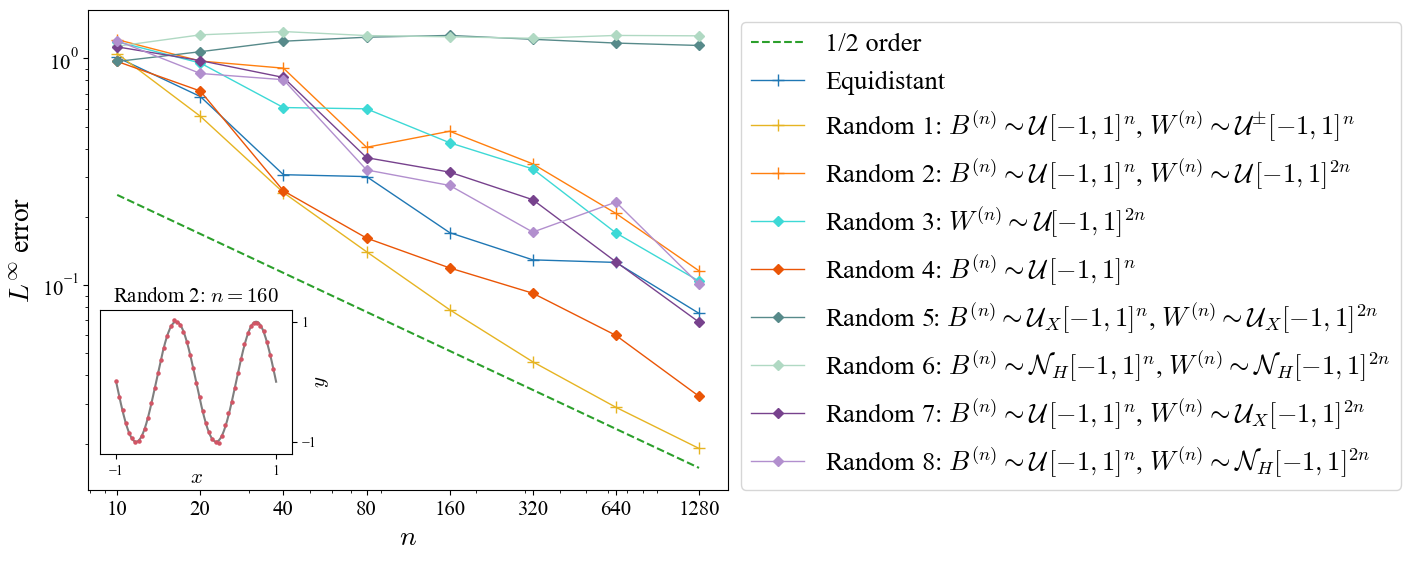

In [ ]:
from statistics import geometric_mean

import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'


x = width_vector
# with adjust
x2 = width_vector_2

begin_point = 2.5E-1

x_ref = [x[0], x[-1]]
y_ref = [begin_point, begin_point/np.sqrt(np.power(2,len(x)))]

ax = plt.figure(figsize=(8, 6))


mean = np.zeros((len(x), num_random))
mean_infty = np.zeros((len(x), num_random))
mean2 = np.zeros((len(x), num_random))
mean_infty2 = np.zeros((len(x), num_random))

y_max = np.zeros((len(width_vector), num_random))
y_min = np.zeros((len(width_vector), num_random))
y_max2 = np.zeros((len(width_vector), num_random))
y_min2 = np.zeros((len(width_vector), num_random))

y_max_infty = np.zeros((len(width_vector), num_random))
y_min_infty = np.zeros((len(width_vector), num_random))
y_max_infty2 = np.zeros((len(width_vector), num_random))
y_min_infty2 = np.zeros((len(width_vector), num_random))

yerr = np.zeros((2, len(width_vector), num_random))
yerr_infty = np.zeros((2, len(width_vector), num_random))
yerr2 = np.zeros((2, len(width_vector), num_random))
yerr_infty2 = np.zeros((2, len(width_vector), num_random))


for l in range(num_random):
    for i in range(len(x)):
        mean[i,l] = geometric_mean(result_matrix[i,:,l])
        mean_infty[i,l] = geometric_mean(result_matrix_infty[i,:,l])

    y_max[:,l] = np.max(result_matrix[:,:,l], axis = 1)
    y_min[:,l] = np.min(result_matrix[:,:,l], axis = 1)
    

    yerr[:,:,l] = np.abs(np.vstack((y_min[:,l], y_max[:,l])) - mean[:,l])


    y_max_infty[:,l] = np.max(result_matrix_infty[:,:,l], axis = 1)
    y_min_infty[:,l] = np.min(result_matrix_infty[:,:,l], axis = 1)

    yerr_infty[:,:,l] = np.abs(np.vstack((y_min_infty[:,l], y_max_infty[:,l])) - mean_infty[:,l])

    
fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])
    
    
plt.plot(x_ref, y_ref, linestyle='--', label='1/2 order', color = 'tab:green')
    
plt.plot(x, mean_infty[:,0], '+', markersize=8, linestyle='solid', linewidth = 1, label='Equidistant', color = 'tab:blue')

plt.plot(x, mean_infty[:,4], '+', markersize=8, linestyle='solid', linewidth = 1, label='Random 1: $B^{(n)} \sim \mathcal{U} \, [-1,1]^n$, $W^{(n)} \sim \mathcal{U}^{\pm}[-1,1]^n$', color = '#e6b422') # random bias & coe different

plt.plot(x, mean_infty[:,1], '+', markersize=8, linestyle='solid', linewidth = 1, label='Random 2: $B^{(n)} \sim \mathcal{U} \, [-1,1]^n$, $W^{(n)} \sim \mathcal{U} \, [-1,1]^{2n}$', color = '#ff7f0e')

plt.plot(x, mean_infty[:,2], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 3: $W^{(n)} \sim \mathcal{U}[-1,1]^{2n}$', color = '#3dd9d6') # random bias
plt.plot(x, mean_infty[:,3], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 4: $B^{(n)} \sim \mathcal{U} \, [-1,1]^n$', color = '#ea5506') # random coe
# plt.plot(x, mean_infty[:,3], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 3: $B^{(n)} \sim \mathcal{U} \, [-1,1]^n$, $W^{(n)} = \{ B^{(n)}, -B^{(n)} \}$', color = '#E17356') # random bias & coe same


plt.plot(x, mean_infty[:,5], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 5: $B^{(n)} \sim \mathcal{U}_X[-1,1]^n$, $W^{(n)} \sim \mathcal{U}_X[-1,1]^{2n}$', color = '#578A8A') # random coe with He normal
# plt.plot(x, mean_infty[:,5], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 6: $B^{(n)} \sim \mathcal{U}_H[-1,1]^n$, $W^{(n)} \sim \mathcal{U}_H[-1,1]^{2n}$', color = '#B0D9C3', zorder = 10) # random coe with He uniform
plt.plot(x, mean_infty[:,6], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 6: $B^{(n)} \sim \mathcal{N}_H[-1,1]^n$, $W^{(n)} \sim \mathcal{N}_H[-1,1]^{2n}$', color = '#B0D9C3')
# plt.plot(x, mean_infty[:,7], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 8: $B^{(n)} \sim \mathcal{N}_X[-1,1]^n$, $W^{(n)} \sim \mathcal{N}_X[-1,1]^{2n}$', color = '#B28FCE', zorder = 5)

# plt.plot(x, mean_infty[:,8], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 7: $B^{(n)} \sim \mathcal{U} \, [-1,1]^n$, $W^{(n)} \sim \mathcal{N}_X[-1,1]^{2n}$', color = '#77428D')
plt.plot(x, mean_infty[:,7], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 7: $B^{(n)} \sim \mathcal{U} \, [-1,1]^n$, $W^{(n)} \sim \mathcal{U}_X[-1,1]^{2n}$', color = '#77428D')
# plt.plot(x, mean_infty[:,10], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 8: $B^{(n)} \sim \mathcal{U} \, [-1,1]^n$, $W^{(n)} \sim \mathcal{U}_H[-1,1]^{2n}$', zorder = 5, color = '#B28FCE')
plt.plot(x, mean_infty[:,8], 'D', markersize=5, linestyle='solid', linewidth = 1, label='Random 8: $B^{(n)} \sim \mathcal{U} \, [-1,1]^n$, $W^{(n)} \sim \mathcal{N}_H[-1,1]^{2n}$', color = '#B28FCE')


plt.yscale('log')
# plt.ylim((1e-9,1))
plt.xscale('log')
plt.xlabel('$n$', size=20)
plt.ylabel('$L^\infty$ error', size=20)

font_legend = {
    'family': 'Times New Roman',
    'weight': 'normal',
    'size': 19,
    # 'style': 'italic'  
}
plt.legend(fontsize=10, loc=(1.02, 0), prop=font_legend)
plt.xticks(x, x, fontsize=15)
plt.yticks(fontsize=15)



l, b, w, h = 0.115, 0.16, 0.24, 0.24
ax2=fig.add_axes([l, b, w, h])
    
plt.plot(x_test.cpu().detach().numpy(), y_test.cpu().detach().numpy(), label='Data', linewidth = 1.5, color = '#7f7f7f', zorder = 1)
plt.scatter(x_test.cpu().detach().numpy()[::8], y_pred[::8], label='n', color = '#D25565', marker=".", s = 20, zorder = 2) 


ax2.yaxis.tick_right()
plt.xlabel('$x$', fontsize=15)
ax2.yaxis.set_label_position('right')
plt.ylabel('$y$', fontsize=15)
plt.title('Random 2: $n = '+str(width_plot)+'$', fontsize=15)

plt.xticks([-1, 1], fontsize=10)
plt.yticks([-1, 1], fontsize=10)

ax2.set_ylim(-1.2, 1.2)
ax2.set_xlim(-1.2, 1.2)

ax2.xaxis.set_label_coords(0.5, -0.1)
ax2.yaxis.set_label_coords(1.1, 0.5)



plt.savefig('plot_random.pdf', bbox_inches='tight')
plt.show()